<h1 class='header'>Time series forecasting of next 24 hours from historical data<h1>
<h4 class='content'>Load data</h4>

In [5]:


import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
filepath = 'D:/User Backup/Downloads/timetable.csv'
df=pd.read_csv(filepath)
df.head()


,Time,Electricity
0,01-Jan-2012 00:00:00,1056
1,01-Jan-2012 01:00:00,1363
2,01-Jan-2012 02:00:00,1240
3,01-Jan-2012 03:00:00,845
4,01-Jan-2012 04:00:00,647


<h4 class='content'>Visualize Data</h4>

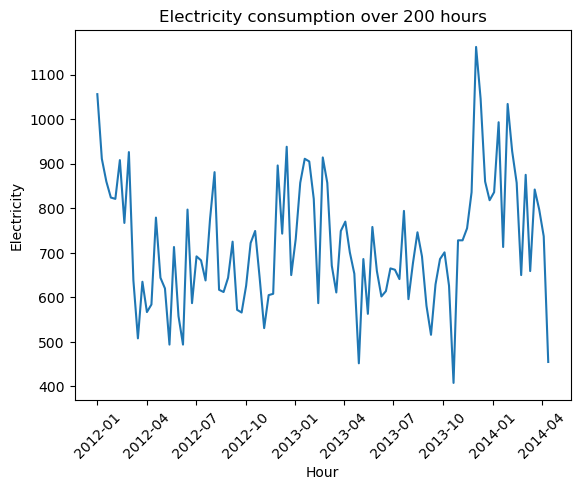

In [7]:
df["Time"]=pd.to_datetime(df["Time"])
hr=np.linspace(0,20000,101)
plt.plot(df['Time'][hr],df['Electricity'][hr])
plt.xlabel('Hour')
plt.xticks(rotation=45)
plt.ylabel('Electricity')
plt.title('Electricity consumption over 200 hours')
plt.show()


<h4 align='center' class='data preparation'>Prepare Data for Forecasting</h4>
<p class='Description'>Use the timetable's data and time information to make distincet variables .Create the hour,day,month</p>
<p class='Description'>Week day,DayOfYear,WeekOfYear varibles in particular,then add them to the timetable</p>

In [8]:

df["Hour"]=df["Time"].dt.hour
df["Day"]=df["Time"].dt.day
df["Month"]=df["Time"].dt.month
df["Weekday"]=df["Time"].dt.weekday
df["DayOfYear"] = df["Time"].dt.isocalendar().day
df['WeekOfYear'] = df['Time'].dt.isocalendar().week


In [9]:
#let the numVar represent how many variables we have in the dataset
num_var=df.shape[1]
num_var


8

<h5 align="left">Normalize variables those have categories of more then 30<h5>

In [10]:

df[["Day", "DayOfYear", "WeekOfYear"]] = df[["Day", "DayOfYear", "WeekOfYear"]].apply(lambda x: (x - x.min()) * (0.5 - (-0.5)) / (x.max() - x.min()) - 0.5)
print(df["Day"].describe())
print(df["DayOfYear"].describe())
print(df["WeekOfYear"].describe())


count    26304.000000
mean        -0.008911
std          0.293385
min         -0.500000
25%         -0.266667
50%          0.000000
75%          0.233333
max          0.500000
Name: Day, dtype: float64
count    26304.000000
mean        -0.000456
std          0.333605
min         -0.500000
25%         -0.333333
50%          0.000000
75%          0.333333
max          0.500000
Name: DayOfYear, dtype: float64
count    26304.000000
mean        -0.000912
std          0.295297
min         -0.500000
25%         -0.264706
50%         -0.009804
75%          0.250000
max          0.500000
Name: WeekOfYear, dtype: float64


</h5>convert catpredictor into dummy variables</5>

In [6]:

cat_predictors = ["Month", "Hour", "Weekday"]


def convert_cat_to_dummy(df, cat_cols):
    for col in cat_cols:
        dummy= pd.get_dummies(df[col], prefix=col, drop_first=True)
        df=pd.concat([df, dummy], axis=1)
        df.drop(col, axis=1, inplace=True)
    
full_data_clean=convert_cat_to_dummy(df, cat_predictors)

<h5>Create lag features to use as predictors by using the shift function</h5>

In [11]:
max_lag = 23
data_with_lags = df.copy()
# Create the lagged features
for i in range(1, max_lag+1):
    neg_lag = df["Electricity"].shift(i)
    neg_lag.name = "ElectricityLag" + str(i)
    data_with_lags = pd.concat([data_with_lags, neg_lag], axis=1)
data_with_lags.head()


,Time,Electricity,Hour,Day,Month,Weekday,DayOfYear,WeekOfYear,ElectricityLag1,ElectricityLag2,...,ElectricityLag14,ElectricityLag15,ElectricityLag16,ElectricityLag17,ElectricityLag18,ElectricityLag19,ElectricityLag20,ElectricityLag21,ElectricityLag22,ElectricityLag23
0,2012-01-01 00:00:00,1056,0,-0.5,1,6,0.5,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 01:00:00,1363,1,-0.5,1,6,0.5,0.5,1056.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 02:00:00,1240,2,-0.5,1,6,0.5,0.5,1363.0,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 03:00:00,845,3,-0.5,1,6,0.5,0.5,1240.0,1363.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 04:00:00,647,4,-0.5,1,6,0.5,0.5,845.0,1240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<p>Prepare Response Variables for the Look-ahead horizons through the shift function where the horizon step number indicates the number of steps the ELectricity data shifted forward in time</p>

In [12]:
# Set the maximum horizon
max_horizon = 24
# Create a copy of the dataWithLags dataframe
full_data = data_with_lags.copy()

# Create the horizon features
for i in range(1, max_horizon+1):
    pos_lag = df["Electricity"].shift(-i)
    pos_lag.name = "ElectricityHorizonStep" + str(i)
    full_data = pd.concat([full_data, pos_lag], axis=1)
full_data.tail()



,Time,Electricity,Hour,Day,Month,Weekday,DayOfYear,WeekOfYear,ElectricityLag1,ElectricityLag2,...,ElectricityHorizonStep15,ElectricityHorizonStep16,ElectricityHorizonStep17,ElectricityHorizonStep18,ElectricityHorizonStep19,ElectricityHorizonStep20,ElectricityHorizonStep21,ElectricityHorizonStep22,ElectricityHorizonStep23,ElectricityHorizonStep24
26299,2014-12-31 19:00:00,1590,19,0.5,12,2,-0.166667,-0.5,1499.0,1085.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26300,2014-12-31 20:00:00,1366,20,0.5,12,2,-0.166667,-0.5,1590.0,1499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26301,2014-12-31 21:00:00,1282,21,0.5,12,2,-0.166667,-0.5,1366.0,1590.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26302,2014-12-31 22:00:00,1261,22,0.5,12,2,-0.166667,-0.5,1282.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26303,2014-12-31 23:00:00,1234,23,0.5,12,2,-0.166667,-0.5,1261.0,1282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3 align='center'>Engineering Features<h3>

In [8]:
start_idx = max_lag + 1
end_idx = full_data.shape[0] - max_horizon
num_predictors = full_data.shape[1] - max_horizon

# Create a subset of the full_data dataframe with no missing values
#data_subset = full_data.iloc[start_idx:end_idx, :].copy()


# Create a subset of the full_data dataframe with no missing values
full_data_no_nan = full_data.dropna()
# Create the X and y dataframes
X = full_data_no_nan.iloc[:, 1:num_predictors]
#categorical predictor
#Categorical predictors are converted to dummy variables

Y=full_data_no_nan.iloc[:,num_predictors:]






In [9]:
X.corr()
Y.corr()

,ElectricityHorizonStep1,ElectricityHorizonStep2,ElectricityHorizonStep3,ElectricityHorizonStep4,ElectricityHorizonStep5,ElectricityHorizonStep6,ElectricityHorizonStep7,ElectricityHorizonStep8,ElectricityHorizonStep9,ElectricityHorizonStep10,...,ElectricityHorizonStep15,ElectricityHorizonStep16,ElectricityHorizonStep17,ElectricityHorizonStep18,ElectricityHorizonStep19,ElectricityHorizonStep20,ElectricityHorizonStep21,ElectricityHorizonStep22,ElectricityHorizonStep23,ElectricityHorizonStep24
ElectricityHorizonStep1,1.000000,0.889203,0.697635,0.482693,0.275143,0.104121,-0.003477,-0.047213,-0.053427,-0.032263,...,0.000735,-0.035855,-0.056268,-0.051143,-0.009245,0.095070,0.260079,0.457854,0.658510,0.827714
ElectricityHorizonStep2,0.889203,1.000000,0.889202,0.697634,0.482705,0.275148,0.104128,-0.003476,-0.047219,-0.053427,...,0.038123,0.000742,-0.035848,-0.056257,-0.051113,-0.009233,0.095064,0.260089,0.457880,0.658523
ElectricityHorizonStep3,0.697635,0.889202,1.000000,0.889204,0.697649,0.482715,0.275157,0.104130,-0.003478,-0.047220,...,0.056598,0.038120,0.000741,-0.035847,-0.056250,-0.051119,-0.009259,0.095053,0.260093,0.457880
ElectricityHorizonStep4,0.482693,0.697634,0.889204,1.000000,0.889210,0.697653,0.482716,0.275157,0.104134,-0.003478,...,0.042684,0.056591,0.038114,0.000733,-0.035862,-0.056257,-0.051117,-0.009252,0.095068,0.260102
ElectricityHorizonStep5,0.275143,0.482705,0.697649,0.889210,1.000000,0.889206,0.697647,0.482714,0.275167,0.104138,...,0.005447,0.042688,0.056592,0.038112,0.000727,-0.035833,-0.056187,-0.051055,-0.009190,0.095113
ElectricityHorizonStep6,0.104121,0.275148,0.482715,0.697653,0.889206,1.000000,0.889203,0.697647,0.482728,0.275170,...,-0.032249,0.005443,0.042681,0.056580,0.038078,0.000730,-0.035770,-0.056135,-0.051007,-0.009160
ElectricityHorizonStep7,-0.003477,0.104128,0.275157,0.482716,0.697647,0.889203,1.000000,0.889205,0.697659,0.482734,...,-0.053385,-0.032244,0.005444,0.042680,0.056569,0.038102,0.000804,-0.035710,-0.056081,-0.050970
ElectricityHorizonStep8,-0.047213,-0.003476,0.104130,0.275157,0.482714,0.697647,0.889205,1.000000,0.889209,0.697659,...,-0.047188,-0.053389,-0.032248,0.005436,0.042656,0.056560,0.038133,0.000826,-0.035694,-0.056073
ElectricityHorizonStep9,-0.053427,-0.047219,-0.003478,0.104134,0.275167,0.482728,0.697659,0.889209,1.000000,0.889204,...,-0.003475,-0.047205,-0.053402,-0.032266,0.005393,0.042605,0.056533,0.038106,0.000798,-0.035722
ElectricityHorizonStep10,-0.032263,-0.053427,-0.047220,-0.003478,0.104138,0.275170,0.482734,0.697659,0.889204,1.000000,...,0.104136,-0.003472,-0.047201,-0.053396,-0.032252,0.005398,0.042604,0.056533,0.038105,0.000796


In [49]:
#
Y.iloc[:,23]

23       1080.0
24        857.0
25        674.0
26        614.0
27        497.0
          ...  
26275    1590.0
26276    1366.0
26277    1282.0
26278    1261.0
26279    1234.0
Name: ElectricityHorizonStep24, Length: 26257, dtype: float64

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Train the model
multiModels = []
for h in range(0, max_horizon):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=30)
    model.fit(X, Y.iloc[:,h])
    multiModels.append(model)



In [11]:
lastT = full_data['Time'].tail(1).values[0]

lastT

numpy.datetime64('2014-12-31T23:00:00.000000000')

In [35]:

# Predict
forecastX=pd.DataFrame(full_data.iloc[[-1],1:num_predictors].values)
lastT = full_data['Time'].tail(1).values[0]+pd.Timedelta(hours=1)
forecastT = pd.date_range(start=lastT, end=lastT+pd.Timedelta(hours=max_horizon-1), freq='H')
forecastX



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1234,23,0.5,12,2,-0.166667,-0.5,1261.0,1282.0,1366.0,...,800.0,662.0,656.0,638.0,560.0,626.0,677.0,788.0,863.0,993.0


In [34]:
forecastY=[]
for h in range(0,max_horizon):
    forecastY.append(multiModels[h].predict(forecastX))



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: U

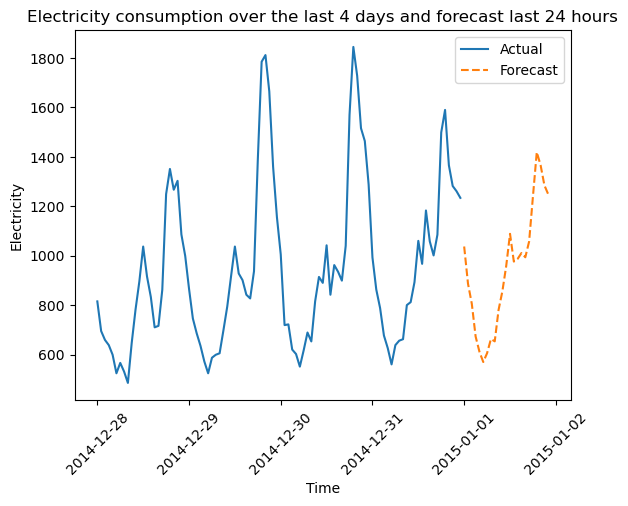

In [30]:
numPastDays = 4
plt.plot(full_data.Time[-24*numPastDays:], full_data.Electricity[-24*numPastDays:])
plt.plot(forecastT[0:23], forecastY,'--')
plt.title('Electricity consumption over the last 4 days and forecast last 24 hours')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time')
plt.ylabel('Electricity')
plt.xticks(rotation=45)
plt.show()